In [1]:
print("""
@File         : ch10_forecasting_multiple_time_series.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-14 18:10:58
@Email        : cuixuanstephen@gmail.com
@Description  : 
""")


@File         : ch10_forecasting_multiple_time_series.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-14 18:10:58
@Email        : cuixuanstephen@gmail.com
@Description  : 



In [2]:
%cd ../

d:\Time-Series\TSFP


In [26]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from utils.print_info import print_adf_result
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

warnings.filterwarnings("ignore")

In [4]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


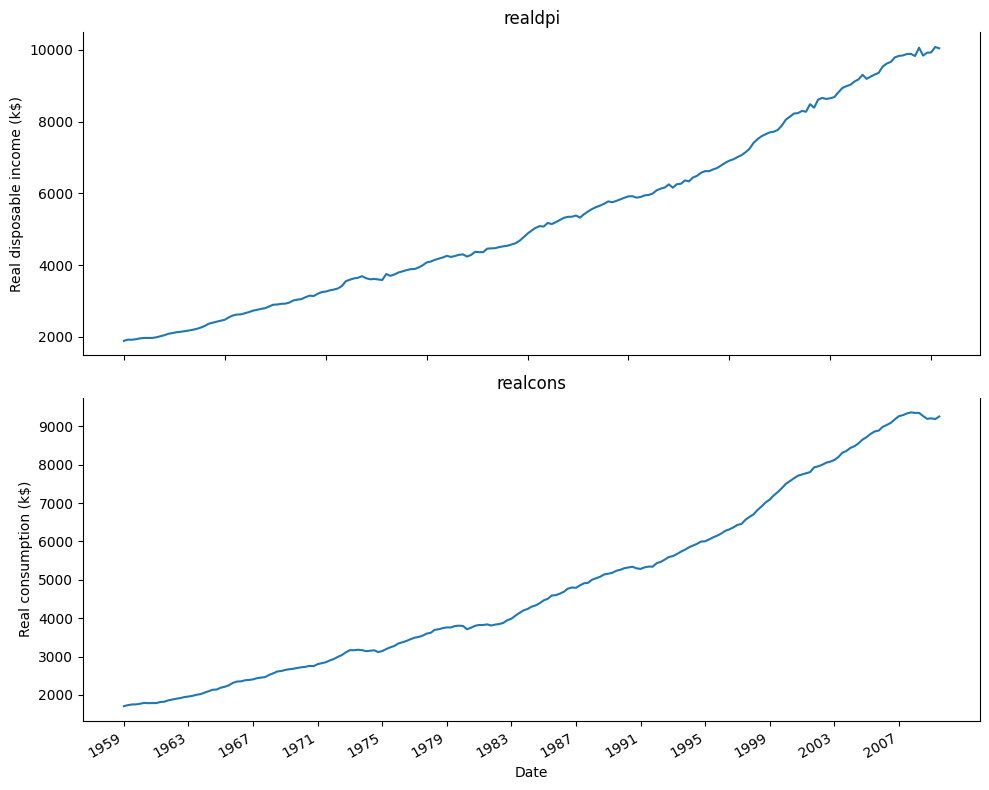

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(macro_econ_data["realdpi"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Real disposable income (k$)")
ax1.set_title("realdpi")
ax1.spines["top"].set_alpha(0)
ax2.plot(macro_econ_data["realcons"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Real consumption (k$)")
ax2.set_title("realcons")
ax2.spines["top"].set_alpha(0)
plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
fig.autofmt_xdate()
plt.tight_layout()

In [6]:
ad_fuller_result_1 = adfuller(macro_econ_data["realdpi"])
print_adf_result(ad_fuller_result_1, 'realdpi')
print("\n---------------------\n")
ad_fuller_result_2 = adfuller(macro_econ_data["realcons"])
print_adf_result(ad_fuller_result_1, 'realcons')

realdpi
ADF Statistic: 2.9860253519546847
p-value: 1.0

---------------------

realcons
ADF Statistic: 2.9860253519546847
p-value: 1.0


In [7]:
ad_fuller_result_1 = np.diff(macro_econ_data["realdpi"], n=1)
print_adf_result(ad_fuller_result_1, "realcons")
print("\n---------------------\n")
ad_fuller_result_2 = np.diff(macro_econ_data["realcons"], n=1)
print_adf_result(ad_fuller_result_2, "realcons")

realcons
ADF Statistic: 32.799999999999955
p-value: -3.2999999999999545

---------------------

realcons
ADF Statistic: 26.299999999999955
p-value: 18.09999999999991


In [8]:
from utils.optimize import optimize_VAR

endog = macro_econ_data[["realdpi", "realcons"]]
endog_diff = endog.diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [09:10<00:00, 36.67s/it]


,p,AIC
0,14,3283.271241
1,13,3164.096609
2,12,3157.703647
3,11,3153.454909
4,10,3147.838841
5,9,3140.367178
6,8,3137.149008
7,1,3134.333343
8,7,3133.395949
9,2,3130.091668


Running the function returns a DataFrame in which we see that $p = 3$ has the lowest AIC value of all. Therefore, the selected model is a VAR(3) model, meaning that the past three values of each time series are used to forecast the other time series.

In [11]:
print("realcons Granger-causes realdpi?\n")
print("------------------")
granger_1 = grangercausalitytests(
    macro_econ_data[["realdpi", "realcons"]].diff()[1:], [3]
)
print("\nrealdpi Granger-causes realcons?\n")
print("------------------")
granger_2 = grangercausalitytests(
    macro_econ_data[["realcons", "realdpi"]].diff()[1:], [3]
)

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


Running the Granger causality test for both variables returns a p-value smaller than 0.05 in both cases. Therefore, we can reject the null hypothesis and conclude that `realdpi` Granger-causes `realcons`, and `realcons` Granger-causes `realdpi`. Our VAR(3) model is thus valid. In the event that one variable does not Granger-cause the other, the VAR(p) model becomes invalid, and it cannot be used. In that case, we must use the SARIMAX model and predict each time series individually.

In [15]:
best_model = VARMAX(train, order=(3, 0))
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Mon, 15 Apr 2024   BIC                           3175.559
Time:                             21:19:54   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

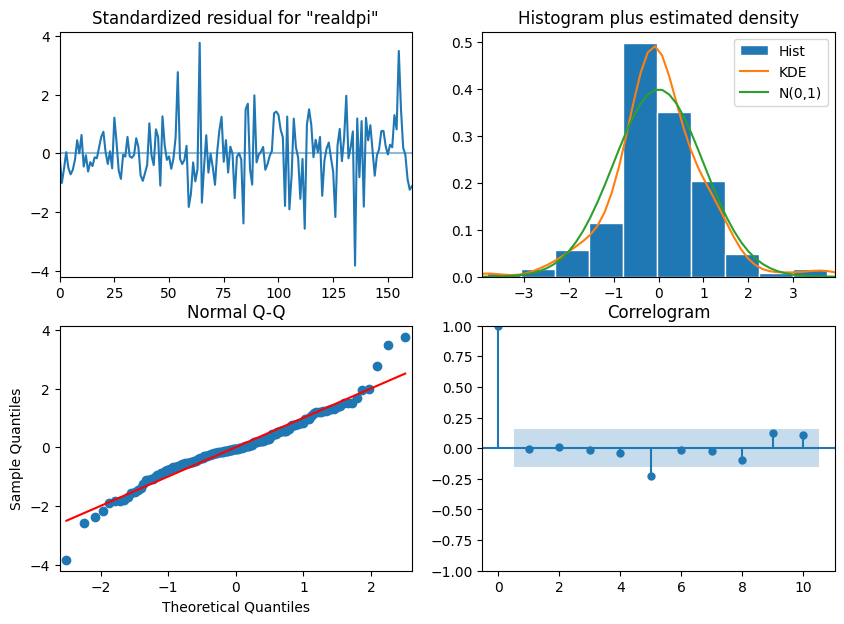

In [18]:
# realdpi
# Passing variable=0 specifies that we want plots for the residuals of
# realdpi, since it is the first variable that was passed to the VAR model.
best_model_fit.plot_diagnostics(figsize=(10, 7), variable=0)
plt.savefig('img/CH10_F04.png', dpi=300)

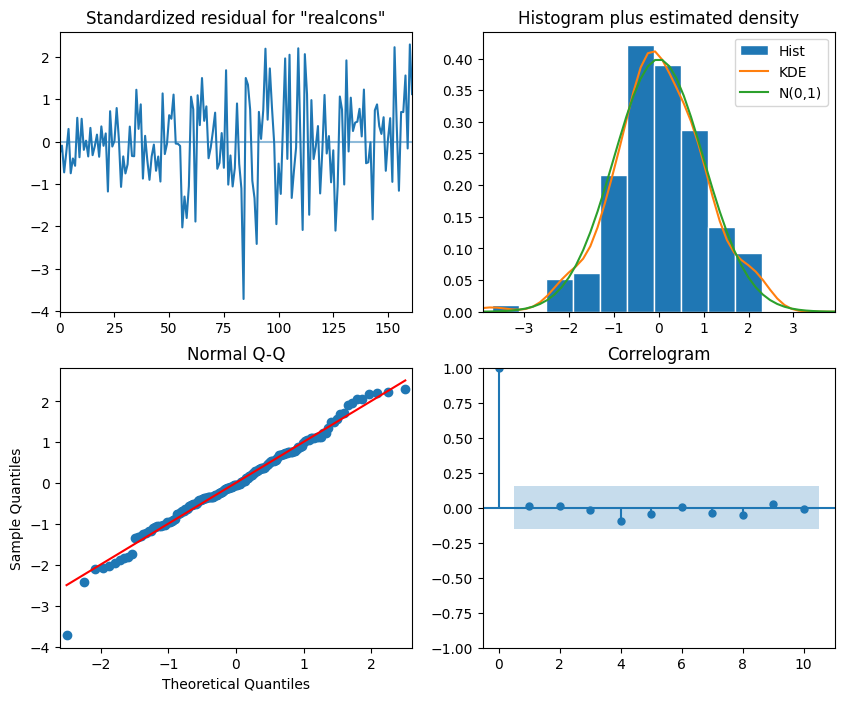

In [19]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10, 8), variable=1)
plt.savefig("img/CH10_F05.png", dpi=300)

In [22]:
realgdp_residuals = best_model_fit.resid["realdpi"]
lb_result = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))
print(lb_result)

      lb_stat  lb_pvalue
1    0.011662   0.914004
2    0.029457   0.985379
3    0.075802   0.994574
4    0.378053   0.984234
5    9.142999   0.103495
6    9.165862   0.164463
7    9.270567   0.233810
8   10.812324   0.212562
9   13.318553   0.148714
10  15.287723   0.121919


In [23]:
realcons_residuals = best_model_fit.resid["realcons"]
lb_result= acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))
print(lb_result)

     lb_stat  lb_pvalue
1   0.023610   0.877882
2   0.068654   0.966255
3   0.068732   0.995305
4   0.235621   0.993582
5   0.377571   0.995925
6   0.787212   0.992412
7   1.015060   0.994582
8   2.150237   0.976056
9   2.436991   0.982530
10  2.442678   0.991685


In [24]:
from utils.forecast import rolling_forecast_varmax

In [25]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast_varmax(
    endog_diff, TRAIN_LEN, HORIZON, WINDOW, "VAR", order=(3, 0)
)

In [31]:
test = endog[163:].copy()
test["realdpi_pred_VAR"] = pd.Series()  # 增加一列全是 NaN 的，为什么要多此一举
# REMOVE
test["realdpi_pred_VAR"] = endog.iloc[162]["realdpi"] + np.cumsum(realdpi_pred_VAR)
test["realcons_pred_VAR"] = pd.Series()
test["realcons_pred_VAR"] = endog.iloc[162]["realcons"] + np.cumsum(realcons_pred_VAR)

In [33]:
test.head()

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.224394,7354.323077
164,8053.4,7501.3,7897.189003,7430.253225
165,8135.9,7571.8,7960.564436,7496.626976
166,8222.3,7645.9,8014.756119,7556.610189
167,8234.6,7713.5,8080.704240,7630.993501


In [36]:
realdpi_pred_baseline, realcons_pred_baseline = rolling_forecast_varmax(
    endog, TRAIN_LEN, HORIZON, WINDOW, "last", order=(3, 0)
)
test["realdpi_pred_baseline"] = realdpi_pred_baseline
test["realcons_pred_baseline"] = realcons_pred_baseline

In [37]:
test.head()

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_baseline,realcons_pred_baseline
163,7887.7,7389.2,7829.224394,7354.323077,7716.0,7199.9
164,8053.4,7501.3,7897.189003,7430.253225,7716.0,7199.9
165,8135.9,7571.8,7960.564436,7496.626976,7716.0,7199.9
166,8222.3,7645.9,8014.756119,7556.610189,7716.0,7199.9
167,8234.6,7713.5,8080.704240,7630.993501,8135.9,7571.8


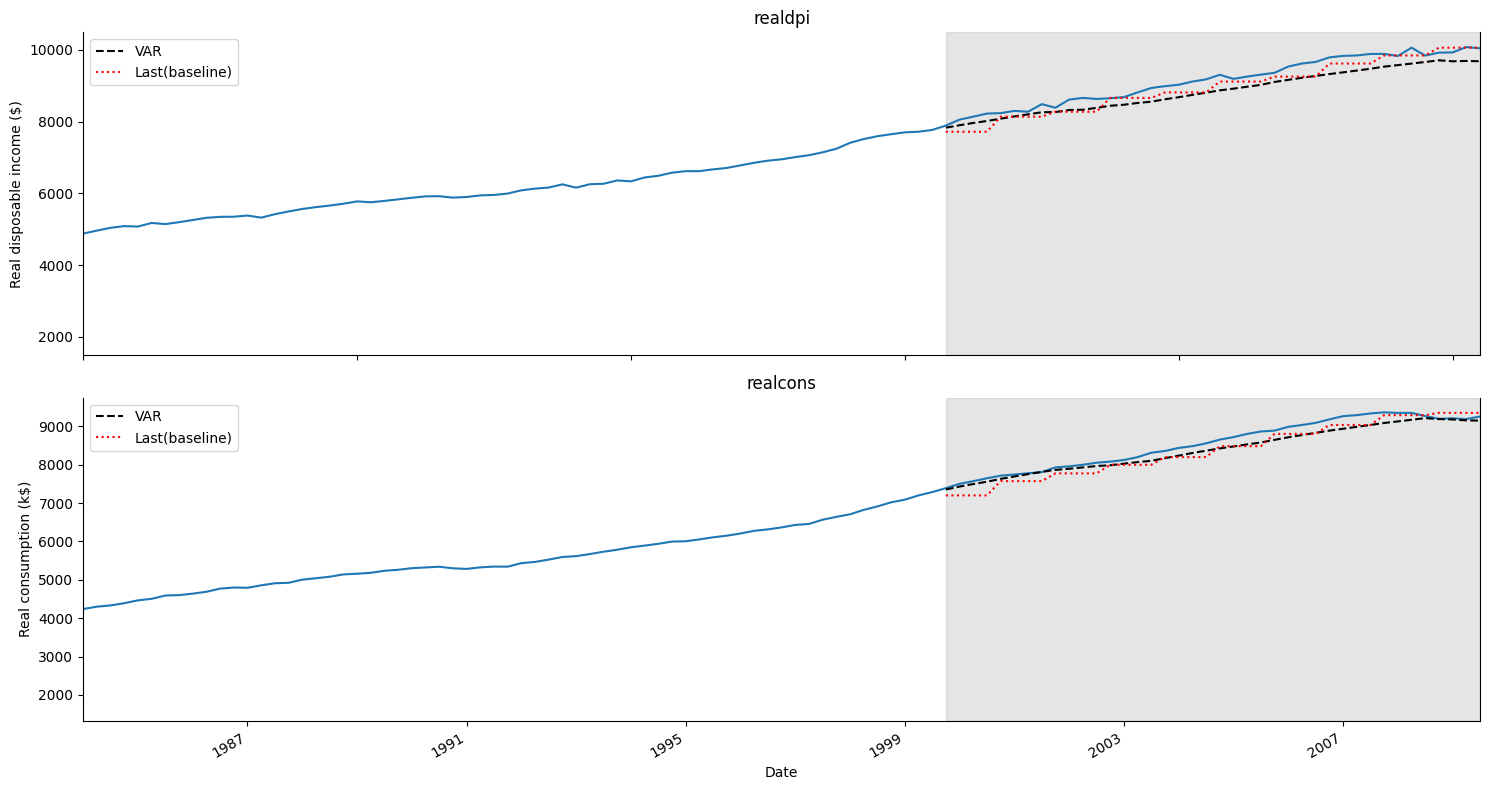

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
ax1.plot(macro_econ_data["realdpi"])
ax1.plot(test["realdpi_pred_VAR"], "k--", label="VAR")
ax1.plot(test["realdpi_pred_baseline"], "r:", label="Last(baseline)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Real disposable income ($)")
ax1.set_title("realdpi")
ax1.spines["top"].set_alpha(0)
ax1.axvspan(163, 202, color="#808080", alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend()
ax2.plot(macro_econ_data["realcons"])
ax2.plot(test["realcons_pred_VAR"], "k--", label="VAR")
ax2.plot(test["realcons_pred_baseline"], "r:", label="Last(baseline)")
ax2.set_xlabel("Date")
ax2.set_ylabel("Real consumption (k$)")
ax2.set_title("realcons")
ax2.spines["top"].set_alpha(0)
ax2.axvspan(163, 202, color="#808080", alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)
plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("img/CH10_F06.png", dpi=300)

In [41]:
from sklearn.metrics import mean_absolute_percentage_error

In [51]:
mape_realdpi_VAR = (
    mean_absolute_percentage_error(test["realdpi"], test["realdpi_pred_VAR"]) * 100
)
mape_realcons_VAR = (
    mean_absolute_percentage_error(test["realcons"], test["realcons_pred_VAR"]) * 100
)
mape_realdpi_baseline = (
    mean_absolute_percentage_error(test["realcons"], test["realcons_pred_baseline"])
    * 100
)
mape_realcons_baseline = (
    mean_absolute_percentage_error(test["realcons"], test["realcons_pred_baseline"])
    * 100
)

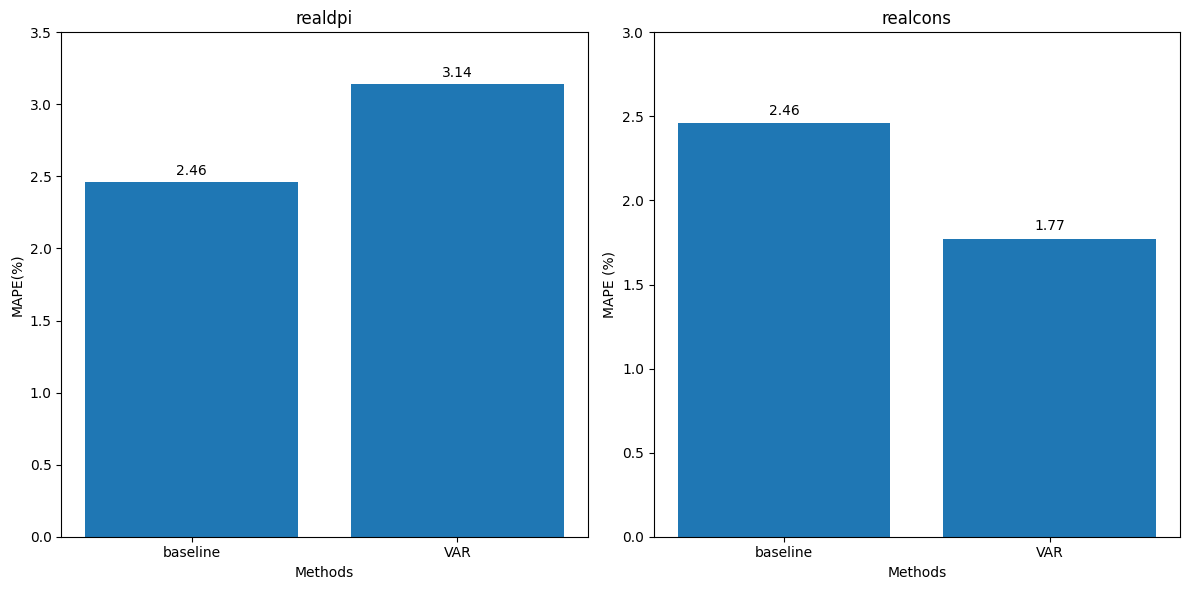

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
x = ["baseline", "VAR"]
y1 = [mape_realdpi_baseline, mape_realdpi_VAR]
y2 = [mape_realcons_baseline, mape_realcons_VAR]
ax1.bar(x, y1)
ax1.set_xlabel("Methods")
ax1.set_ylabel("MAPE(%)")
ax1.set_title("realdpi")
ax1.set_ylim(0, 3.5)

ax2.bar(x, y2)
ax2.set_xlabel("Methods")
ax2.set_ylabel("MAPE (%)")
ax2.set_title("realcons")
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value, 2)), ha="center")
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value, 2)), ha="center")
plt.tight_layout()
plt.savefig("img/CH10_F07.png", dpi=300)